In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

from torchvision import datasets, transforms

print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
True


# Hyper Parameters

In [2]:
TRAIN = True
USE_GPU = True
device = torch.device('cuda') if USE_GPU and torch.cuda.is_available() else torch.device('cpu')
    
IMG_SIZE = 28*28
BATCH_SIZE = 100
LEARNING_RATE = 1e-4

# Data : mnist

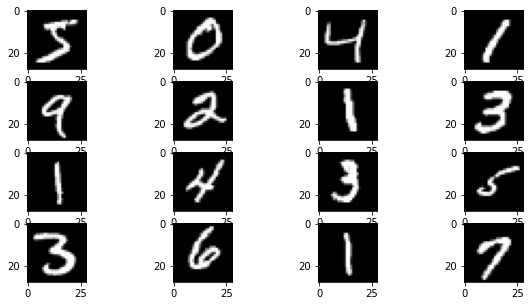

In [3]:
# transforms.Compose : 데이터를 전처리하는 패키지.

train_dataset = datasets.MNIST('../mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor
                             ]))

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# for visualize
train_images = train_dataset.data

fig = plt.figure(figsize=(10,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.squeeze(train_images[i]), cmap='gray')
plt.show()

# Model : VAE

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # encoder
        self.d1 = nn.Linear(784, 512)
        self.d2 = nn.Linear(512, 256)
        self.d31 = nn.Linear(256, 2)
        self.d32 = nn.Linear(256, 2)
        
        # decoder
        self.d4 = nn.Linear(2, 256)
        self.d5 = nn.Linear(256, 512)
        self.d6 = nn.Linear(512, 784)

    def encode(self, x):
        out = F.relu(self.d1(x))
        out = F.relu(self.d2(out))
        mu = self.d31(out)
        log_var = self.d32(out)
        return mu, log_var
    
    def reparameterization(self, mu, log_var):
        epsilon = torch.randn(mu.shape).to(device)
        std = torch.exp(0.5*log_var)    
        z = std*epsilon + mu
        return z
    
    def decode(self, z):
        out = F.relu(self.d4(z))
        out = F.relu(self.d5(out))
        out = torch.sigmoid(self.d6(out))
        return out
        
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterization(mu, log_var)
        
        x_hat = self.decode(z)
        
        return x_hat, mu, log_var
    
vae = VAE().to(device)

In [5]:
vae

VAE(
  (d1): Linear(in_features=784, out_features=512, bias=True)
  (d2): Linear(in_features=512, out_features=256, bias=True)
  (d31): Linear(in_features=256, out_features=2, bias=True)
  (d32): Linear(in_features=256, out_features=2, bias=True)
  (d4): Linear(in_features=2, out_features=256, bias=True)
  (d5): Linear(in_features=256, out_features=512, bias=True)
  (d6): Linear(in_features=512, out_features=784, bias=True)
)

# loss

In [6]:
def loss_func(x, x_hat, mu, log_var):
    bce = F.binary_cross_entropy(x_hat, x.view(-1,784),reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kld

# Optimizer

In [7]:
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Train

In [12]:
def train(vae, train_loader, epochs,
          show=True
         ):
    
    vae.train()
    loss_history = []
    for epoch in range(epochs):
        
        for idx, (x,_) in enumerate(train_loader):
            
            x = x.to(device)
            
            optimizer.zero_grad()
            
            x_hat, mu, log_var = vae(x)
            
            loss = loss_func(x, x_hat, mu, log_var)
            
            loss.backward()
            optimizer.step()
            
            
            loss_history.append(loss.item())
            
            if idx % 100 == 0:
                print('Epoch {:4} : [{:5}/{}] loss : {}'.format(
                    epoch,idx*BATCH_SIZE,len(train_loader.dataset), loss.item()) )
                
        if show:
            fig = plt.figure(figsize = (9,3))
            for i in range(3):
                plt.subplot(1,3,i+1)
                plt.yticks([])
                plt.xticks([])
                plt.imshow(x_hat[i*10].detach().cpu().numpy().reshape(28,28),cmap='gray')
            plt.show()
                
    return loss_history

Epoch    0 : [    0/60000] loss : 16681.07421875
Epoch    0 : [10000/60000] loss : 17762.744140625
Epoch    0 : [20000/60000] loss : 16331.4443359375
Epoch    0 : [30000/60000] loss : 17444.66796875
Epoch    0 : [40000/60000] loss : 16804.013671875
Epoch    0 : [50000/60000] loss : 16816.96484375


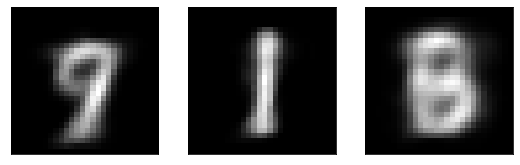

Epoch    1 : [    0/60000] loss : 16514.201171875
Epoch    1 : [10000/60000] loss : 17226.125
Epoch    1 : [20000/60000] loss : 17549.287109375
Epoch    1 : [30000/60000] loss : 16577.4375
Epoch    1 : [40000/60000] loss : 16871.474609375
Epoch    1 : [50000/60000] loss : 16061.359375


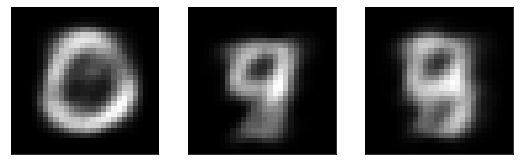

Epoch    2 : [    0/60000] loss : 16194.8134765625
Epoch    2 : [10000/60000] loss : 16311.8056640625
Epoch    2 : [20000/60000] loss : 17176.4453125
Epoch    2 : [30000/60000] loss : 15774.888671875
Epoch    2 : [40000/60000] loss : 16542.302734375
Epoch    2 : [50000/60000] loss : 16181.2421875


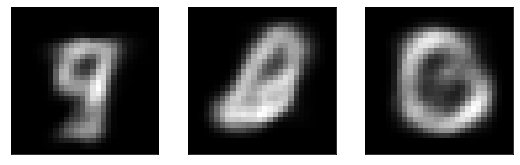

Epoch    3 : [    0/60000] loss : 16617.04296875
Epoch    3 : [10000/60000] loss : 15705.83984375
Epoch    3 : [20000/60000] loss : 16140.51953125
Epoch    3 : [30000/60000] loss : 15455.1337890625
Epoch    3 : [40000/60000] loss : 17057.279296875
Epoch    3 : [50000/60000] loss : 15682.125


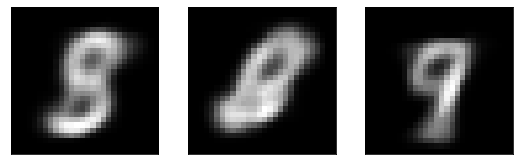

Epoch    4 : [    0/60000] loss : 15598.126953125
Epoch    4 : [10000/60000] loss : 16216.2412109375
Epoch    4 : [20000/60000] loss : 16177.7138671875
Epoch    4 : [30000/60000] loss : 16633.802734375
Epoch    4 : [40000/60000] loss : 15741.1865234375
Epoch    4 : [50000/60000] loss : 16241.1416015625


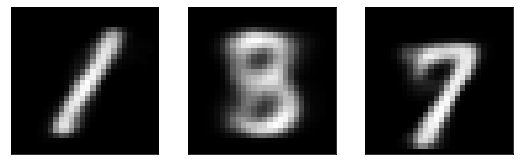

Epoch    5 : [    0/60000] loss : 16357.36328125
Epoch    5 : [10000/60000] loss : 15520.474609375
Epoch    5 : [20000/60000] loss : 15691.029296875
Epoch    5 : [30000/60000] loss : 15150.4736328125
Epoch    5 : [40000/60000] loss : 15525.744140625
Epoch    5 : [50000/60000] loss : 16249.7607421875


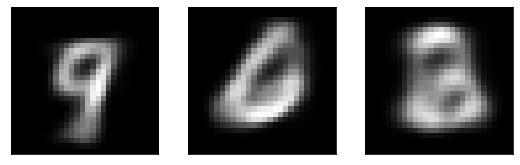

Epoch    6 : [    0/60000] loss : 16289.529296875
Epoch    6 : [10000/60000] loss : 14873.9736328125
Epoch    6 : [20000/60000] loss : 15977.2255859375
Epoch    6 : [30000/60000] loss : 15844.4619140625
Epoch    6 : [40000/60000] loss : 16250.025390625
Epoch    6 : [50000/60000] loss : 16942.392578125


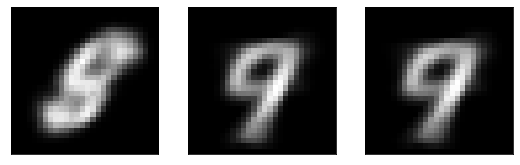

Epoch    7 : [    0/60000] loss : 15776.2646484375
Epoch    7 : [10000/60000] loss : 16778.41015625
Epoch    7 : [20000/60000] loss : 15836.587890625
Epoch    7 : [30000/60000] loss : 15450.779296875
Epoch    7 : [40000/60000] loss : 16015.1025390625
Epoch    7 : [50000/60000] loss : 15503.9384765625


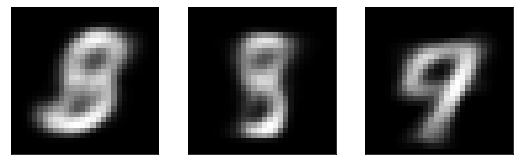

Epoch    8 : [    0/60000] loss : 14481.7900390625
Epoch    8 : [10000/60000] loss : 15402.9765625
Epoch    8 : [20000/60000] loss : 15104.90234375
Epoch    8 : [30000/60000] loss : 14731.1123046875
Epoch    8 : [40000/60000] loss : 15108.115234375
Epoch    8 : [50000/60000] loss : 15881.9599609375


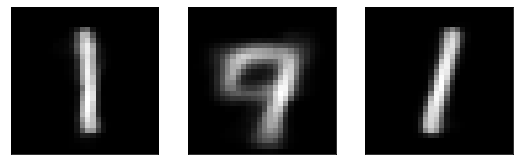

Epoch    9 : [    0/60000] loss : 15510.6162109375
Epoch    9 : [10000/60000] loss : 15082.0478515625
Epoch    9 : [20000/60000] loss : 15836.0400390625
Epoch    9 : [30000/60000] loss : 16016.3642578125
Epoch    9 : [40000/60000] loss : 15533.0947265625
Epoch    9 : [50000/60000] loss : 16266.353515625


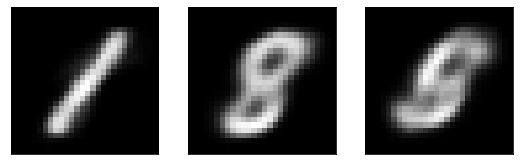

Epoch   10 : [    0/60000] loss : 15115.2705078125
Epoch   10 : [10000/60000] loss : 16225.216796875
Epoch   10 : [20000/60000] loss : 15282.9404296875
Epoch   10 : [30000/60000] loss : 15604.0654296875
Epoch   10 : [40000/60000] loss : 15165.4970703125
Epoch   10 : [50000/60000] loss : 15736.7431640625


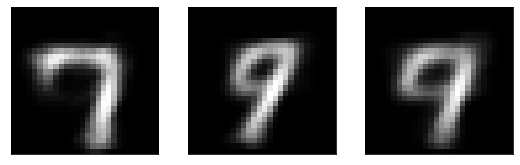

Epoch   11 : [    0/60000] loss : 15772.4052734375
Epoch   11 : [10000/60000] loss : 14993.220703125
Epoch   11 : [20000/60000] loss : 15281.0078125
Epoch   11 : [30000/60000] loss : 15337.1943359375
Epoch   11 : [40000/60000] loss : 14470.580078125
Epoch   11 : [50000/60000] loss : 14746.9091796875


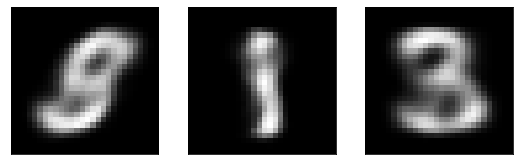

Epoch   12 : [    0/60000] loss : 15453.484375
Epoch   12 : [10000/60000] loss : 13491.4443359375
Epoch   12 : [20000/60000] loss : 16059.068359375
Epoch   12 : [30000/60000] loss : 14241.0576171875
Epoch   12 : [40000/60000] loss : 15119.0576171875
Epoch   12 : [50000/60000] loss : 14200.2626953125


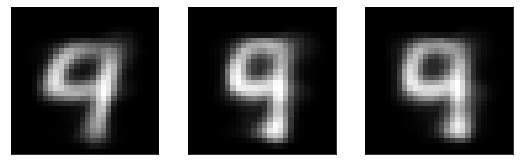

Epoch   13 : [    0/60000] loss : 14996.046875
Epoch   13 : [10000/60000] loss : 15077.3212890625
Epoch   13 : [20000/60000] loss : 15565.1416015625
Epoch   13 : [30000/60000] loss : 15070.1982421875
Epoch   13 : [40000/60000] loss : 14884.173828125
Epoch   13 : [50000/60000] loss : 15360.775390625


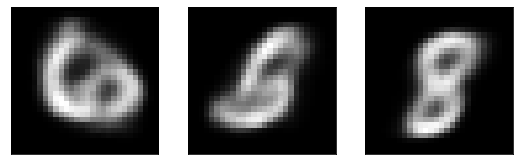

Epoch   14 : [    0/60000] loss : 14513.80859375
Epoch   14 : [10000/60000] loss : 14699.5302734375
Epoch   14 : [20000/60000] loss : 14265.2958984375
Epoch   14 : [30000/60000] loss : 14866.5693359375
Epoch   14 : [40000/60000] loss : 15778.5380859375
Epoch   14 : [50000/60000] loss : 15208.25


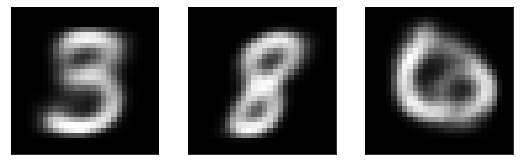

Epoch   15 : [    0/60000] loss : 14927.1103515625
Epoch   15 : [10000/60000] loss : 15431.212890625
Epoch   15 : [20000/60000] loss : 15617.8642578125
Epoch   15 : [30000/60000] loss : 15185.958984375
Epoch   15 : [40000/60000] loss : 14786.4541015625
Epoch   15 : [50000/60000] loss : 15077.482421875


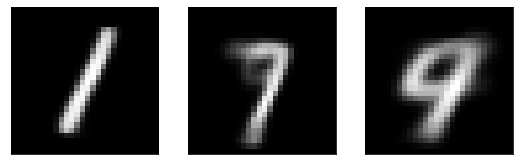

Epoch   16 : [    0/60000] loss : 14775.6953125
Epoch   16 : [10000/60000] loss : 14530.228515625
Epoch   16 : [20000/60000] loss : 15049.796875
Epoch   16 : [30000/60000] loss : 15171.3603515625
Epoch   16 : [40000/60000] loss : 14112.400390625
Epoch   16 : [50000/60000] loss : 14254.2548828125


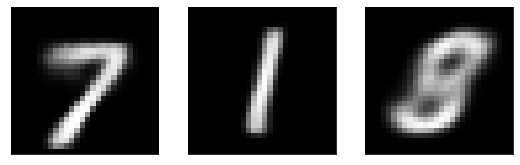

Epoch   17 : [    0/60000] loss : 15237.26953125
Epoch   17 : [10000/60000] loss : 13860.783203125
Epoch   17 : [20000/60000] loss : 15095.404296875
Epoch   17 : [30000/60000] loss : 15226.115234375
Epoch   17 : [40000/60000] loss : 14160.689453125
Epoch   17 : [50000/60000] loss : 15285.044921875


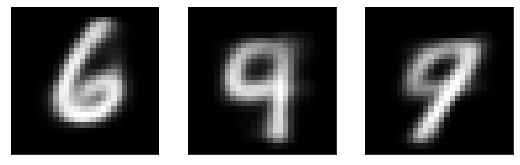

Epoch   18 : [    0/60000] loss : 15200.0263671875
Epoch   18 : [10000/60000] loss : 14315.2626953125
Epoch   18 : [20000/60000] loss : 15296.3662109375
Epoch   18 : [30000/60000] loss : 15150.43359375
Epoch   18 : [40000/60000] loss : 14155.0224609375
Epoch   18 : [50000/60000] loss : 14869.447265625


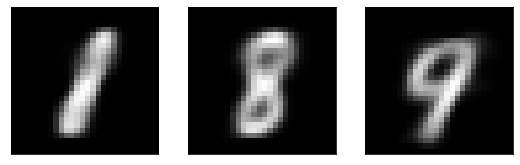

Epoch   19 : [    0/60000] loss : 14396.109375
Epoch   19 : [10000/60000] loss : 15510.3896484375
Epoch   19 : [20000/60000] loss : 14594.2041015625
Epoch   19 : [30000/60000] loss : 14552.7880859375
Epoch   19 : [40000/60000] loss : 15108.935546875
Epoch   19 : [50000/60000] loss : 16047.53125


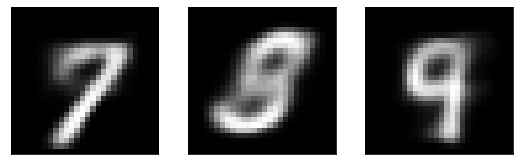

Epoch   20 : [    0/60000] loss : 15128.880859375
Epoch   20 : [10000/60000] loss : 14923.1611328125
Epoch   20 : [20000/60000] loss : 15049.197265625
Epoch   20 : [30000/60000] loss : 14732.615234375
Epoch   20 : [40000/60000] loss : 14420.2919921875
Epoch   20 : [50000/60000] loss : 14869.44140625


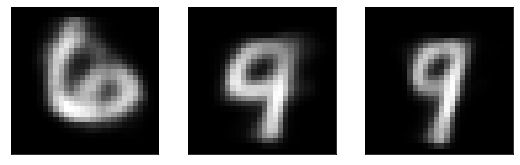

Epoch   21 : [    0/60000] loss : 14929.9501953125
Epoch   21 : [10000/60000] loss : 14512.515625
Epoch   21 : [20000/60000] loss : 15468.341796875
Epoch   21 : [30000/60000] loss : 14575.26171875
Epoch   21 : [40000/60000] loss : 15312.0400390625
Epoch   21 : [50000/60000] loss : 14457.23046875


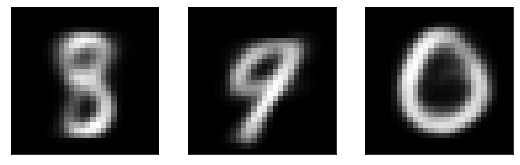

Epoch   22 : [    0/60000] loss : 15287.4072265625
Epoch   22 : [10000/60000] loss : 15242.611328125
Epoch   22 : [20000/60000] loss : 14690.1591796875
Epoch   22 : [30000/60000] loss : 14035.2158203125
Epoch   22 : [40000/60000] loss : 15186.744140625
Epoch   22 : [50000/60000] loss : 14971.1357421875


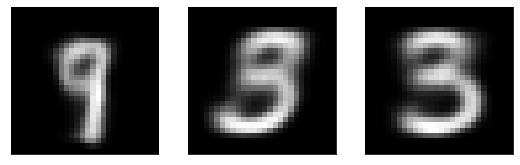

Epoch   23 : [    0/60000] loss : 14494.8662109375
Epoch   23 : [10000/60000] loss : 14470.033203125
Epoch   23 : [20000/60000] loss : 14649.533203125
Epoch   23 : [30000/60000] loss : 14667.5947265625
Epoch   23 : [40000/60000] loss : 15092.36328125
Epoch   23 : [50000/60000] loss : 14902.271484375


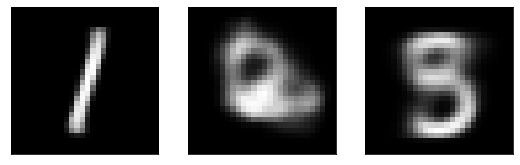

Epoch   24 : [    0/60000] loss : 14711.0419921875
Epoch   24 : [10000/60000] loss : 14692.7822265625
Epoch   24 : [20000/60000] loss : 14227.673828125
Epoch   24 : [30000/60000] loss : 13950.8037109375
Epoch   24 : [40000/60000] loss : 14441.15625
Epoch   24 : [50000/60000] loss : 14201.126953125


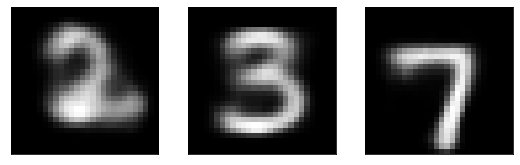

Epoch   25 : [    0/60000] loss : 14292.9140625
Epoch   25 : [10000/60000] loss : 13996.341796875
Epoch   25 : [20000/60000] loss : 14785.1962890625
Epoch   25 : [30000/60000] loss : 13560.6669921875
Epoch   25 : [40000/60000] loss : 13986.80078125
Epoch   25 : [50000/60000] loss : 14685.3408203125


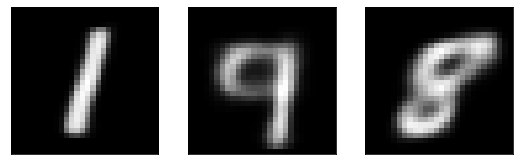

Epoch   26 : [    0/60000] loss : 14396.146484375
Epoch   26 : [10000/60000] loss : 15208.2802734375
Epoch   26 : [20000/60000] loss : 14233.4072265625
Epoch   26 : [30000/60000] loss : 14389.6884765625
Epoch   26 : [40000/60000] loss : 14256.6708984375
Epoch   26 : [50000/60000] loss : 14311.8408203125


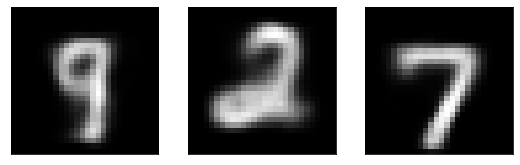

Epoch   27 : [    0/60000] loss : 14981.7099609375
Epoch   27 : [10000/60000] loss : 14677.9072265625
Epoch   27 : [20000/60000] loss : 14513.955078125
Epoch   27 : [30000/60000] loss : 14311.697265625
Epoch   27 : [40000/60000] loss : 14586.5341796875
Epoch   27 : [50000/60000] loss : 14949.2490234375


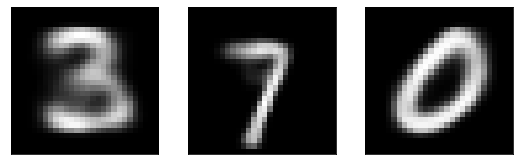

Epoch   28 : [    0/60000] loss : 13977.5703125
Epoch   28 : [10000/60000] loss : 13826.734375
Epoch   28 : [20000/60000] loss : 13916.201171875
Epoch   28 : [30000/60000] loss : 14558.9267578125
Epoch   28 : [40000/60000] loss : 14106.4501953125
Epoch   28 : [50000/60000] loss : 13844.388671875


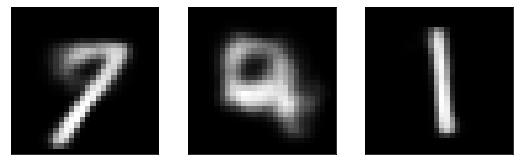

Epoch   29 : [    0/60000] loss : 14757.7421875
Epoch   29 : [10000/60000] loss : 14383.0546875
Epoch   29 : [20000/60000] loss : 15786.49609375
Epoch   29 : [30000/60000] loss : 13775.8876953125
Epoch   29 : [40000/60000] loss : 14492.1845703125
Epoch   29 : [50000/60000] loss : 14861.9599609375


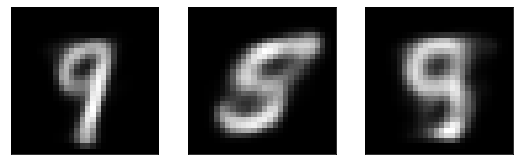

Epoch   30 : [    0/60000] loss : 14348.640625
Epoch   30 : [10000/60000] loss : 14395.0576171875
Epoch   30 : [20000/60000] loss : 14372.84765625
Epoch   30 : [30000/60000] loss : 14213.4052734375
Epoch   30 : [40000/60000] loss : 15125.0703125
Epoch   30 : [50000/60000] loss : 14309.6865234375


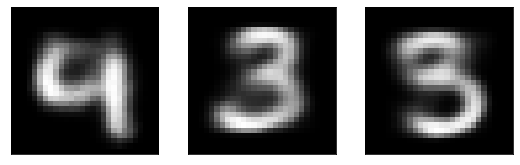

Epoch   31 : [    0/60000] loss : 14649.9892578125
Epoch   31 : [10000/60000] loss : 14725.7392578125
Epoch   31 : [20000/60000] loss : 13698.7880859375
Epoch   31 : [30000/60000] loss : 14077.1650390625
Epoch   31 : [40000/60000] loss : 14573.216796875
Epoch   31 : [50000/60000] loss : 13944.830078125


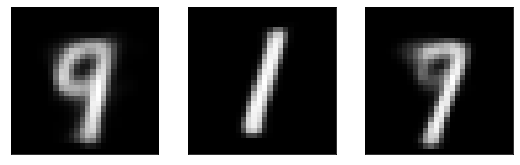

Epoch   32 : [    0/60000] loss : 14401.400390625
Epoch   32 : [10000/60000] loss : 14595.5341796875
Epoch   32 : [20000/60000] loss : 14863.9267578125
Epoch   32 : [30000/60000] loss : 14403.0068359375
Epoch   32 : [40000/60000] loss : 14541.50390625
Epoch   32 : [50000/60000] loss : 14652.2451171875


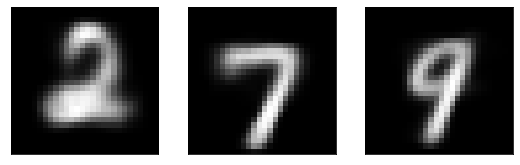

Epoch   33 : [    0/60000] loss : 13997.3671875
Epoch   33 : [10000/60000] loss : 14242.974609375
Epoch   33 : [20000/60000] loss : 13924.5576171875
Epoch   33 : [30000/60000] loss : 14440.44140625
Epoch   33 : [40000/60000] loss : 15166.5263671875
Epoch   33 : [50000/60000] loss : 14354.7783203125


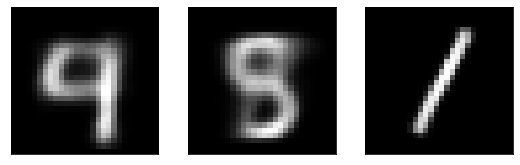

Epoch   34 : [    0/60000] loss : 14198.5830078125
Epoch   34 : [10000/60000] loss : 14044.30078125
Epoch   34 : [20000/60000] loss : 14671.5576171875
Epoch   34 : [30000/60000] loss : 14145.98828125
Epoch   34 : [40000/60000] loss : 15242.89453125
Epoch   34 : [50000/60000] loss : 14764.7158203125


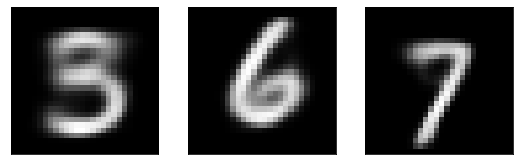

Epoch   35 : [    0/60000] loss : 14498.357421875
Epoch   35 : [10000/60000] loss : 14085.9453125
Epoch   35 : [20000/60000] loss : 14818.375
Epoch   35 : [30000/60000] loss : 14259.681640625
Epoch   35 : [40000/60000] loss : 14235.02734375
Epoch   35 : [50000/60000] loss : 13377.142578125


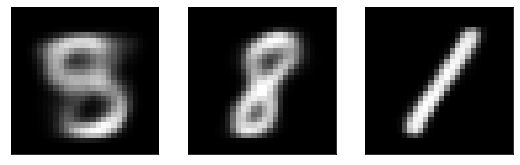

Epoch   36 : [    0/60000] loss : 13141.8603515625
Epoch   36 : [10000/60000] loss : 14248.755859375
Epoch   36 : [20000/60000] loss : 13757.029296875
Epoch   36 : [30000/60000] loss : 15375.7021484375
Epoch   36 : [40000/60000] loss : 14402.4326171875
Epoch   36 : [50000/60000] loss : 13699.158203125


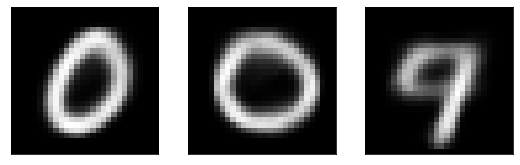

Epoch   37 : [    0/60000] loss : 13895.7158203125
Epoch   37 : [10000/60000] loss : 14776.974609375
Epoch   37 : [20000/60000] loss : 14486.6591796875
Epoch   37 : [30000/60000] loss : 14502.6953125
Epoch   37 : [40000/60000] loss : 14540.0048828125
Epoch   37 : [50000/60000] loss : 14817.9228515625


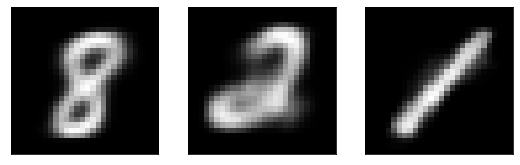

Epoch   38 : [    0/60000] loss : 15326.2958984375
Epoch   38 : [10000/60000] loss : 15716.296875
Epoch   38 : [20000/60000] loss : 15020.380859375
Epoch   38 : [30000/60000] loss : 14248.5693359375
Epoch   38 : [40000/60000] loss : 14195.322265625
Epoch   38 : [50000/60000] loss : 14644.564453125


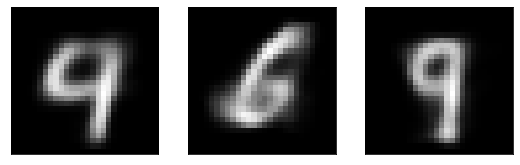

Epoch   39 : [    0/60000] loss : 13952.4638671875
Epoch   39 : [10000/60000] loss : 14901.857421875
Epoch   39 : [20000/60000] loss : 13940.689453125
Epoch   39 : [30000/60000] loss : 14665.869140625
Epoch   39 : [40000/60000] loss : 14845.6416015625
Epoch   39 : [50000/60000] loss : 14263.5498046875


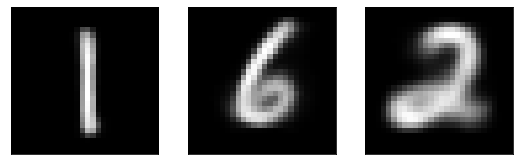

Epoch   40 : [    0/60000] loss : 14238.4033203125
Epoch   40 : [10000/60000] loss : 14840.9931640625
Epoch   40 : [20000/60000] loss : 13619.9990234375
Epoch   40 : [30000/60000] loss : 14758.9951171875
Epoch   40 : [40000/60000] loss : 14746.27734375
Epoch   40 : [50000/60000] loss : 15309.0556640625


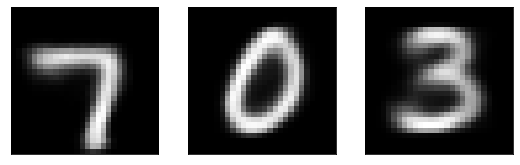

Epoch   41 : [    0/60000] loss : 14218.537109375
Epoch   41 : [10000/60000] loss : 14494.171875
Epoch   41 : [20000/60000] loss : 13934.59765625
Epoch   41 : [30000/60000] loss : 15655.7685546875
Epoch   41 : [40000/60000] loss : 14149.8701171875
Epoch   41 : [50000/60000] loss : 14165.16796875


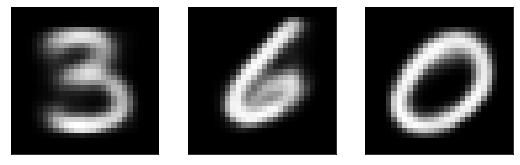

Epoch   42 : [    0/60000] loss : 13566.19921875
Epoch   42 : [10000/60000] loss : 14623.474609375
Epoch   42 : [20000/60000] loss : 13204.203125
Epoch   42 : [30000/60000] loss : 14215.3525390625
Epoch   42 : [40000/60000] loss : 13371.494140625
Epoch   42 : [50000/60000] loss : 13860.947265625


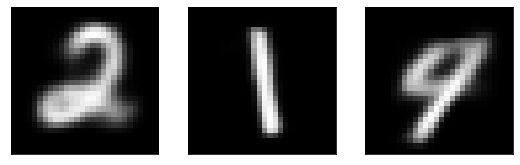

Epoch   43 : [    0/60000] loss : 14748.947265625
Epoch   43 : [10000/60000] loss : 13184.8076171875
Epoch   43 : [20000/60000] loss : 14470.703125
Epoch   43 : [30000/60000] loss : 13909.056640625
Epoch   43 : [40000/60000] loss : 14073.4443359375
Epoch   43 : [50000/60000] loss : 14471.736328125


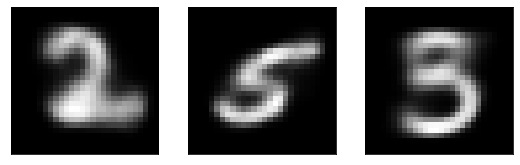

Epoch   44 : [    0/60000] loss : 14185.416015625
Epoch   44 : [10000/60000] loss : 14236.3896484375
Epoch   44 : [20000/60000] loss : 13511.578125
Epoch   44 : [30000/60000] loss : 13696.02734375
Epoch   44 : [40000/60000] loss : 14225.8544921875
Epoch   44 : [50000/60000] loss : 15380.8427734375


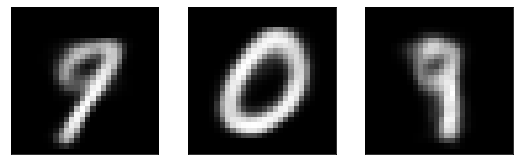

Epoch   45 : [    0/60000] loss : 13502.4873046875
Epoch   45 : [10000/60000] loss : 13788.0283203125
Epoch   45 : [20000/60000] loss : 14253.99609375
Epoch   45 : [30000/60000] loss : 14686.04296875
Epoch   45 : [40000/60000] loss : 14311.4853515625
Epoch   45 : [50000/60000] loss : 15143.9638671875


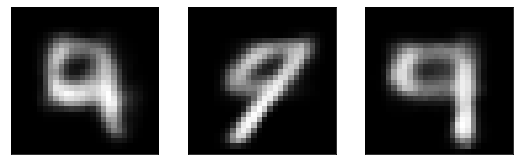

Epoch   46 : [    0/60000] loss : 14944.7900390625
Epoch   46 : [10000/60000] loss : 13074.8974609375
Epoch   46 : [20000/60000] loss : 13843.44921875
Epoch   46 : [30000/60000] loss : 13897.29296875
Epoch   46 : [40000/60000] loss : 13587.8271484375
Epoch   46 : [50000/60000] loss : 13986.2509765625


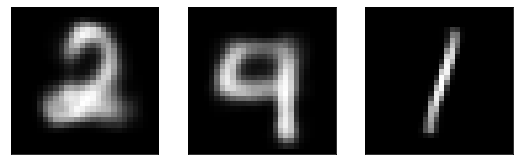

Epoch   47 : [    0/60000] loss : 14294.833984375
Epoch   47 : [10000/60000] loss : 14128.7041015625
Epoch   47 : [20000/60000] loss : 13695.630859375
Epoch   47 : [30000/60000] loss : 14218.55859375
Epoch   47 : [40000/60000] loss : 14234.84375
Epoch   47 : [50000/60000] loss : 14462.47265625


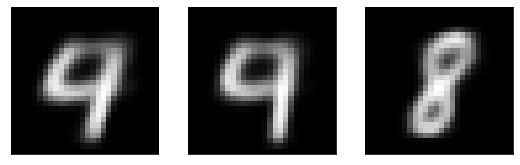

Epoch   48 : [    0/60000] loss : 14001.2919921875
Epoch   48 : [10000/60000] loss : 15064.5869140625
Epoch   48 : [20000/60000] loss : 14182.47265625
Epoch   48 : [30000/60000] loss : 14344.9462890625
Epoch   48 : [40000/60000] loss : 14891.2177734375
Epoch   48 : [50000/60000] loss : 14341.8203125


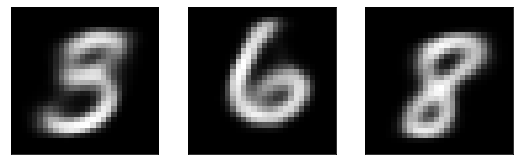

Epoch   49 : [    0/60000] loss : 14231.05859375
Epoch   49 : [10000/60000] loss : 13834.3173828125
Epoch   49 : [20000/60000] loss : 14136.0068359375
Epoch   49 : [30000/60000] loss : 14683.2216796875
Epoch   49 : [40000/60000] loss : 14182.3505859375
Epoch   49 : [50000/60000] loss : 13906.6123046875


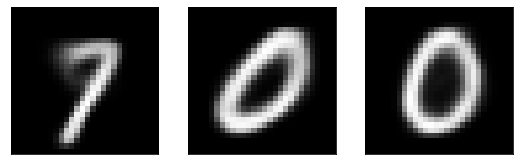

In [13]:
if TRAIN:
    loss_history = train(vae, train_loader, 50)
else:
    print("TRAIN = False !")

# Save model

In [14]:
if TRAIN:
    save_path = './model'
    torch.save(vae, save_path + '/vae.pth')
    torch.save(loss_history, save_path + '/loss_history')

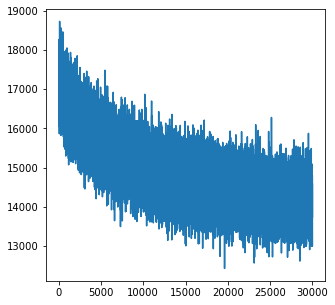

In [15]:
if TRAIN:
    fig = plt.figure(figsize=(5,5))
    plt.plot(loss_history)
    plt.show()

# Load model

In [16]:
load_path = 'model'
vae = torch.load(load_path + '/vae.pth')

# Manifold visualize

In [17]:
x = np.linspace(-2.0, 2.0, 20)
y = np.linspace(-2.0, 2.0, 20)

In [18]:
z=[]
for x_ in x:
    for y_ in y:
        z.append((x_,y_))
z = torch.FloatTensor(z).to(device)
print(z.shape)

torch.Size([400, 2])


In [19]:
with torch.no_grad():
    x_hat = vae.decode(z)
    print(x_hat)
    print(x_hat.shape)

tensor([[1.8594e-13, 2.0253e-14, 2.8620e-14,  ..., 1.4556e-14, 3.0848e-14,
         8.5103e-15],
        [6.7497e-13, 8.3933e-14, 1.0263e-13,  ..., 5.4075e-14, 1.0000e-13,
         3.5457e-14],
        [1.3414e-12, 1.9602e-13, 2.1415e-13,  ..., 1.2655e-13, 2.0414e-13,
         8.4917e-14],
        ...,
        [8.2407e-15, 3.9792e-16, 3.1197e-16,  ..., 2.2464e-15, 6.4450e-16,
         2.1230e-15],
        [2.2324e-15, 1.2253e-16, 7.6300e-17,  ..., 7.7086e-16, 1.6346e-16,
         6.4423e-16],
        [6.1553e-16, 3.8596e-17, 1.9417e-17,  ..., 2.7564e-16, 4.3895e-17,
         1.9624e-16]], device='cuda:0')
torch.Size([400, 784])


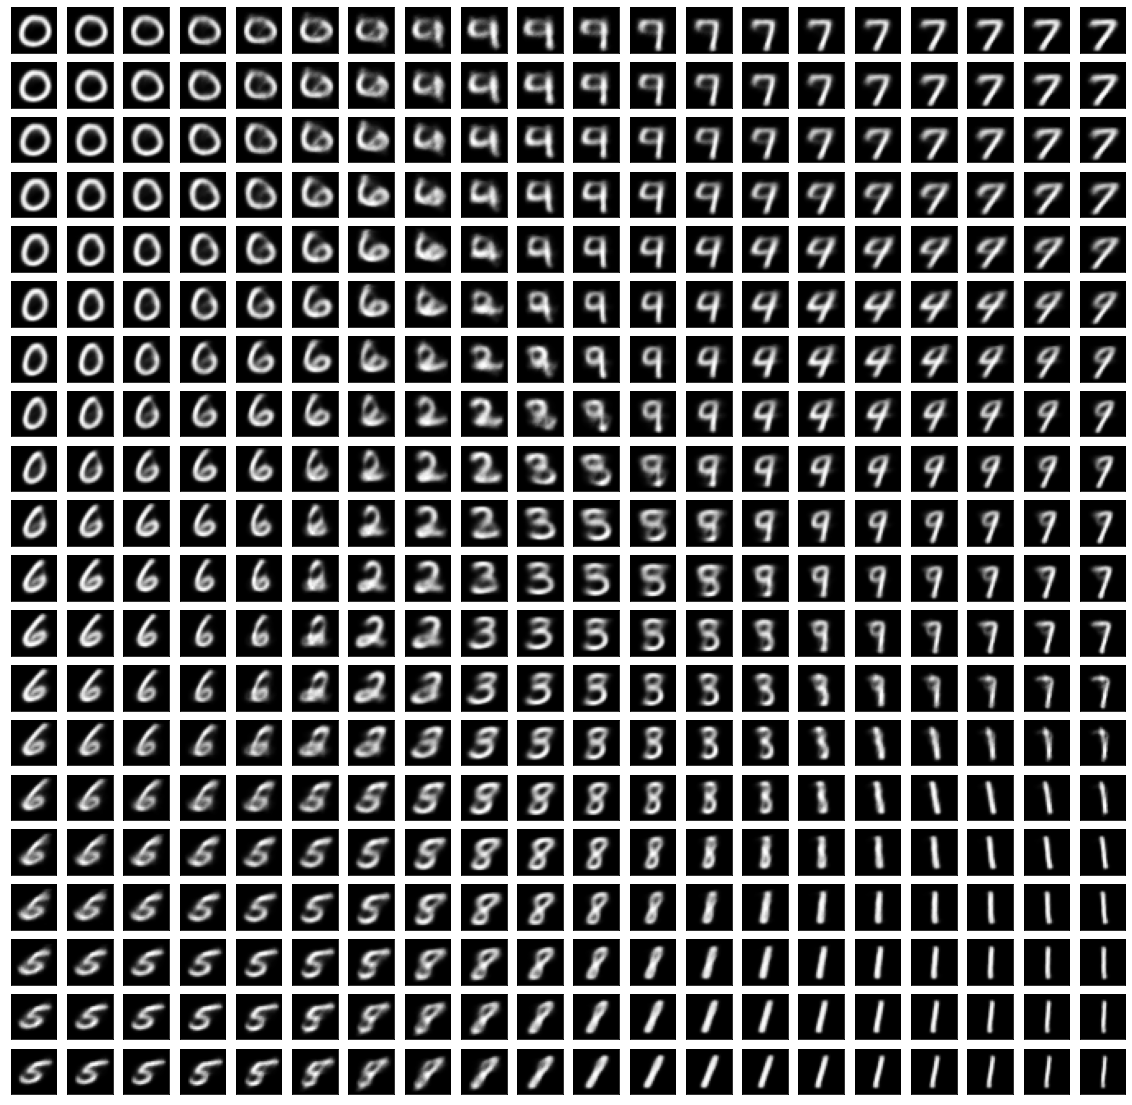

In [20]:
fig = plt.figure(figsize=(20,20))
for i in range(400):
    plt.subplot(20,20,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_hat[i].detach().cpu().numpy().reshape(28,28), cmap='gray')
plt.show()